In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path 

import albumentations.augmentations.transforms as A
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import pytorch_lightning as pl
import torchvision.utils as utils
from albumentations.core.composition import Compose
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.metrics import roc_auc_score
from PIL import Image

from ml.data import RazncrDataModule
from ml.utils import plot_a_batch

In [3]:
data_path = Path('../data/')

In [4]:
train = pd.read_csv('../data/train_folds.csv')
train.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID,kfold
0,1.2.826.0.1.3680043.8.498.11129277979862559057...,0,0,1,0,0,1,0,0,0,1,1,8849382d0,0
1,1.2.826.0.1.3680043.8.498.11050967545366588098...,0,0,0,0,0,0,0,0,0,1,0,6341a7664,0
2,1.2.826.0.1.3680043.8.498.12104979387919011811...,0,0,0,0,0,0,0,0,1,0,0,5169ae6e3,0
3,1.2.826.0.1.3680043.8.498.10756893264881684897...,0,0,0,0,0,0,0,0,0,1,0,eb2b8c9ae,0
4,1.2.826.0.1.3680043.8.498.73379559589406887236...,0,0,0,1,0,0,0,0,0,1,0,64f279182,0


In [5]:
target_cols = train.columns[1:-2]

## Check label distribution on training set

In [6]:
train.loc[:, target_cols].mean()

ETT - Abnormal                0.002626
ETT - Borderline              0.037829
ETT - Normal                  0.240667
NGT - Abnormal                0.009274
NGT - Borderline              0.017585
NGT - Incompletely Imaged     0.091347
NGT - Normal                  0.159459
CVC - Abnormal                0.106206
CVC - Borderline              0.281222
CVC - Normal                  0.708839
Swan Ganz Catheter Present    0.027590
dtype: float64

## Use observed frequency on training set as predictions

In [7]:
pred = train.loc[:, target_cols].mean().values
y_pred = np.tile(pred, (train.shape[0], 1))
y_pred.shape

(30083, 11)

In [8]:
y_true = train.loc[:, target_cols].values
roc_auc_score(y_true, y_pred, average="macro")

0.5

## RandomForest + ImageNet embeddings 

In [9]:
SZ = 128

In [10]:
train_augmentation = Compose([
    A.Resize(SZ, SZ),
    ToTensorV2()
])
dm = RazncrDataModule(
    data_path=data_path, 
    fold=0, 
    batch_size=32,
    train_augmentation=train_augmentation,
    valid_augmentation=train_augmentation,  # TODO: create valid_augmentation
    test_augmentation=train_augmentation    # TODO: create test_augmentation
)
dm.setup()

In [11]:
dl = dm.train_dataloader()

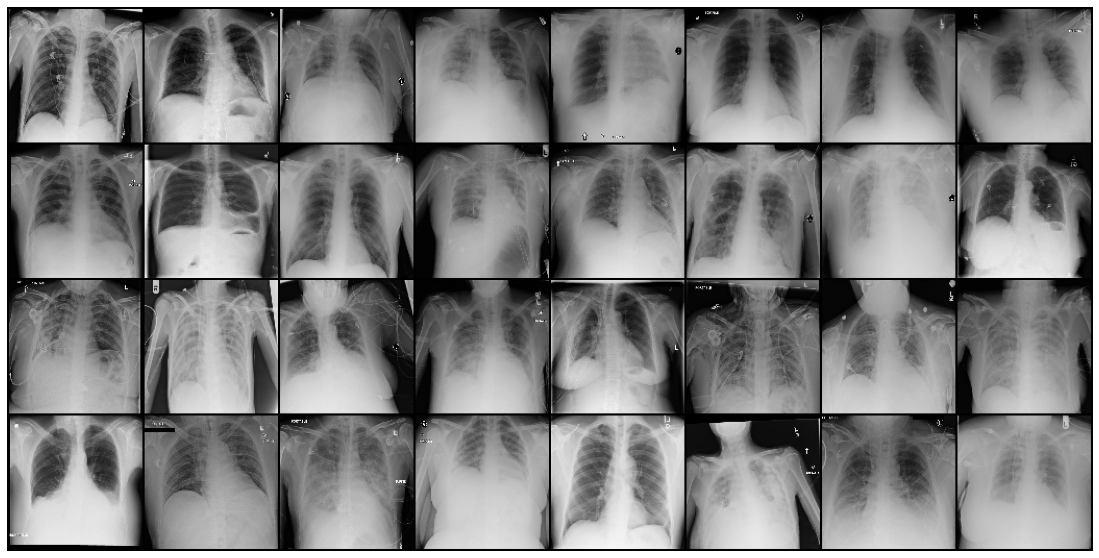

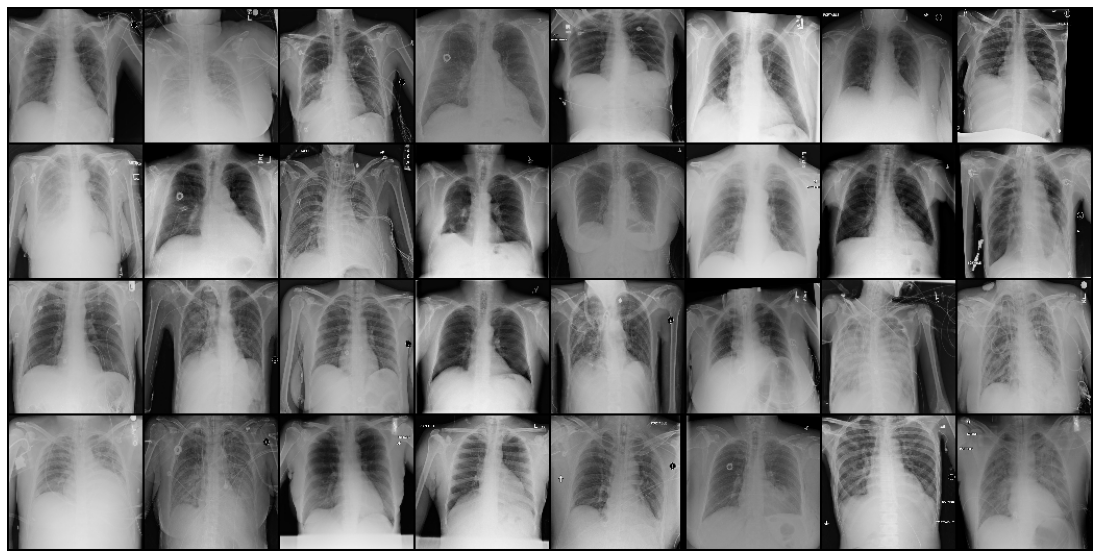

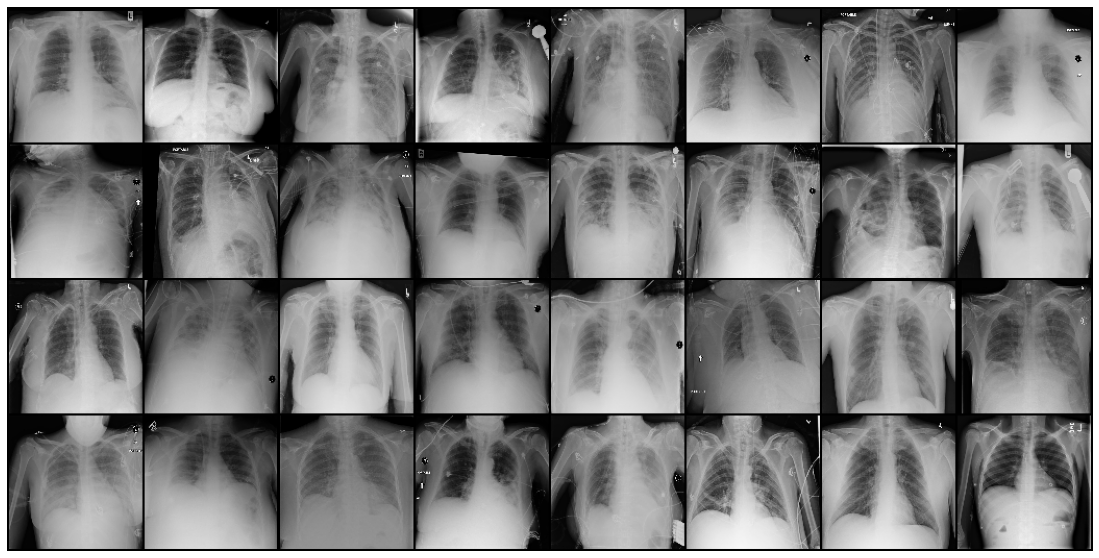

In [12]:
plot_a_batch(dl=dl)